## <span style="color:blue">Lac Leman: beach litter surveys Nov 2015 - Nov 2020</span>

### <span style="color:#008891">Draft -- summary analysis year over year results</span>

1. method and scope
2. number of surveys and locations per sample year, median, avegeran and total quantity
3. number of surveys per location and year
4. survey totals pieces per meter Nov 2015 - Nov 2020, grouped by team
5. distribution of results year over year ---not started
questions or comments: analyst@hammerdirt.ch

### <span style="color:#1e90ff">Methods</span>

#### **<span style="color:#008891">Data source, time frame, geographic scope and collection methods </span>**

The data for this analysis is the results from beach-litter surveys conducted in Switzerland, on the shores of Lac Léman from Nov 2015 - Nov 2020.

The data was collected according to the protocol described here [https://www.plagespropres.ch/](https://www.plagespropres.ch/). In brief all visible data is collected along a beach within a measured distance from the waters edge. The width of the survey area depends on the terrain and the water level. The visible strand line or the nearest physical structure defines the width of a survey.

Surveys were conducted by the following organizations:

1. hammerdirt
2. Association pour le Sauvegarde du leman
3. Solid Waste Management Ecole Polytechnique Federal
4. Ecole International de Geneve
5. Precious plastic leman

This analysis is an open source document. The working note book is available in the repository located here [https://github.com/hammerdirt-analyst/patelmanuscript](https://github.com/hammerdirt-analyst/patelmanuscript).

In [1]:
# sys, file and nav packages:
import os
import datetime as dt
import csv

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
import datetime as dt 
from statsmodels.distributions.empirical_distribution import ECDF


# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
import seaborn as sns
import matplotlib.gridspec as gridspec


# mapping
import geopandas as gpd


# home brew utitilties
import utilities.utility_functions as ut

# documenting
from IPython.display import display, HTML
from IPython.display import Markdown as md

# convenience functions for tables
def make_table_grids(anax):
    anax.grid(False)
    anax.spines["top"].set_visible(False)
    anax.spines["right"].set_visible(False)
    anax.spines["bottom"].set_visible(False)
    anax.spines["left"].set_visible(False)
    return(anax)

def table_fonts(a_table, size=12):
    a_table.auto_set_font_size(False)
    a_table.set_fontsize(size)


# standard formats already in use for charts, these will gradually
# define the chart style or output format for the app
# you can just apply these as kwargs to different elements...


# table kwargs
table_k = dict(loc="top left", bbox=(0,0,1,1), colWidths=[.5, .5], cellLoc='center')
tablecenter_k = dict(loc="top left", bbox=(0,0,1,1), cellLoc='center')
tabtickp_k = dict(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelleft=False, labelbottom=False)

# chart kwargs
title_k = {'loc':'left', 'pad':12, 'linespacing':1.5, 'fontsize':12}
title_k20 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
title_k17 = {'loc':'left', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
titler_k20 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'dodgerblue'}
titler_k17 = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12, 'color':'salmon'}
xlab_k = {'labelpad':18, 'fontsize':12}
ylab_k = {'labelpad':21, 'fontsize':14}
titler_k = {'loc':'right', 'pad':10, 'linespacing':1.5, 'fontsize':12}

# use these to format date axis in charts
weeks = mdates.WeekdayLocator(byweekday=1, interval=4)
onedayweek = mdates.DayLocator(bymonthday=1, interval=1)
everytwoweeks = mdates.WeekdayLocator(byweekday=1, interval=4)

months = mdates.MonthLocator(bymonth=[3,6,9,12])
bimonthly = mdates.MonthLocator(bymonth=[1,3,5,7,9,11])
allmonths = mdates.MonthLocator()
wks_fmt = mdates.DateFormatter('%d')
mths_fmt = mdates.DateFormatter('%b')


In [2]:
# the local file structure. The resources are located in the corresponding directory.
survey_data, location_data, code_defs, stat_ent, geo_data, output = ut.make_local_paths()

# set some parameters:
start_date = '2020-04-01'
end_date = dt.datetime.today().strftime('%Y-%m-%d')


year_one = {"start_date":"2015-11-01", "end_date":"2016-10-31"}
year_two = {"start_date":"2016-11-01", "end_date":"2017-10-31"}
year_three = {"start_date":"2017-11-01", "end_date":"2018-10-31"}
year_four = {"start_date":"2018-11-01", "end_date":"2019-10-31"}
year_five = {"start_date":"2019-11-01", "end_date":"2020-10-31"}

years = [year_one, year_two, year_three, year_four, year_five]
year_names = ['year one', 'year two', 'year three', 'year four', 'year five']


# define a code group, there are predefined code groups in
# the resources folder under mlwcodedefs
const = ut.json_file_get(F"{output}/code_groups/construction.json")
group_one = ['G27','G35', 'G30', 'G25','G31','G32','G33','G34', 'G21', 'G24']
group_one_name = "kiosk waste"
code = "gone"
group_names = [group_one_name]

# define a second group or leave as all
# this note book will only compare the two groups 
group_two = const
group_two_name = 'construction waste'
code = "gtwo"

# keep track of the figures you produce
table_num = 1
figure_num = 1
map_num = 1


# choose a lake:
lake = 'Lac Léman'

# define a significant event:
sig = .9
one_minus_sig = (1-sig)

# define explanatory variables:
expv = ['population','streets','buildings','rivs']

# name the folder:
name_of_project = 'yearoneThroughFive'

# use this to store things:
project_directory = ut.make_project_folder(output, name_of_project)
data_directory = ut.make_project_folder(project_directory,"data")

# probably want to keep these... the works already done
# aggregated survey data
dfAgg = pd.read_csv(F"{survey_data}/results_with_zeroes_aggregated_parent.csv")
dfAgg['date'] = pd.to_datetime(dfAgg['date'])

# add the loc_date column
dfAgg['loc_date'] = list(zip(dfAgg.location, dfAgg.date.dt.strftime('%Y-%m-%d')))
dfAgg['loc_date'] = dfAgg.loc_date.map(lambda x: F"{x}")

# limit the data to the lake of choice and the max date:
dfAgg = dfAgg.loc[(dfAgg.water_name == lake)&(dfAgg.date <= year_five['end_date'])]
dfAgg = dfAgg[dfAgg.date != "2019-01-16"]

# non aggregated survey data
dfSurveys = pd.read_csv(F"{survey_data}/results_with_zeroes.csv")
dfSurveys['date'] = pd.to_datetime(dfSurveys['date'])
dfSurveys = dfSurveys.loc[dfSurveys.water_name == lake]

# beach data
dfBeaches = pd.read_csv(F"{location_data}/beaches_with_ranks.csv")
dfBeaches.set_index('slug', inplace=True)
dfBeaches.rename(columns={"NUMPOINTS":"intersects"}, inplace=True)
dfBeaches = dfBeaches.loc[dfBeaches.water_name == lake]

# code definitions
dfCodes = pd.read_csv(F"{code_defs}/mlw_codes.csv")

# geo data: explantory variables, index by slug and make a map:
dfStreets = pd.read_csv(F"{geo_data}/exp_variables/strasse_1000.csv", index_col='slug')['length']
dfBlds = pd.read_csv(F"{geo_data}/exp_variables/builds_500.csv", index_col='slug')['surface']
dfRivs = dfBeaches['intersects']

In [3]:
# using aggregated data:
dfS = dfAgg

# map geo values to survey results:
dfS['population']=dfS.location.map(lambda x: dfBeaches.loc[x]['population'])
dfS['streets'] = dfS.location.map(lambda x: dfStreets.loc[x])
dfS['buildings'] = dfS.location.map(lambda x: dfBlds.loc[x])
dfS['rivs'] = dfS.location.map(lambda x: dfRivs.loc[x])

# get a list of the codes in the current data
codes_in_use = dfS.code.unique()

# seperate out group_one:
dfGone = dfS.loc[dfS.code.isin(group_one)].copy()

# group all the codes in group 2 or all the codes not in group one
if 'all' in group_two:
    dfGtwo = dfS.loc[~dfS.code.isin(group_one)].copy()
    group_two_name = 'the rest'
else:
    dfGtwo = dfS.loc[dfS.code.isin(group_two)].copy()

group_names.append(group_two_name)

# gather up the created dataframes
groupdfs = [dfGone,dfGtwo]

# get the codes that have been accounted for in groupone and grouptwo:
codes_accounted_for = set(list(dfGone.code.unique())) | set(list(dfGtwo.code.unique()))

# get the codes that have not been accounted for
group_three = [x for x in codes_in_use if x not in codes_accounted_for]

# make a boolean to alert to the presence of data in group three
# if you choose all as the second group then groupthree will be empty
gthree = len(group_three) > 0

# keep track of the files you are exporting:
files_generated = []

# method to save
def add_output(a_name, a_tag, atype="table", fignum=0, a_list=files_generated):
    tableonefile = F"{project_directory}/{a_name}"
    files_generated.append({'tag':a_tag, 'number':fignum, 'file':tableonefile,'type':atype})
    plt.savefig(tableonefile, dpi=300)
def add_csv_to_output(a_name, a_tag, somdata, atype="data", a_list=files_generated, data_directory=data_directory):
    a_file_name = F"{data_directory}/{a_name}"
    files_generated.append({'tag':a_tag, 'file':a_name,'type':atype})
    somdata.to_csv(a_file_name, index=False)
    

# save files
add_csv_to_output('survey_data.csv', 'All survey data, by location, date, code', dfS)
add_csv_to_output('beach_data.csv', 'Survey location data', dfBeaches)


# daily totals for each group
# and assign the name 'rest' to either group_two or group_three
# that depends on the value of group_two
if gthree:
    group_three_name = 'the rest'
    dfGthree = dfS.loc[dfS.code.isin(group_three)].copy()
    project_groups = [group_one, group_two, group_three]
    group_names.append(group_three_name)
    groupdfs.append(dfGthree)
else:
    project_groups = [group_one, group_two]

# put the dfs in a dictionary and key to group name
groupdfs = {x:groupdfs[i] for i,x in enumerate(group_names)}

# name the columns to keep when aggregating:
cols_to_keep = ['loc_date','location','water_name', 'date','population','streets','buildings','rivs']

# get the daily total for each group and store in a data frame:
for name in group_names:
    new_name = F"{name}_dt"
    dtdf = groupdfs[name].groupby(cols_to_keep, as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})    
    dtdf.set_index('loc_date', inplace=True)
    groupdfs.update({new_name:dtdf})

# get each survey total per location and date (all codes included)
allDf = dfS.groupby(['loc_date','location','water_name', 'date','population','streets','buildings','rivs'], as_index=False).agg({"pcs_m":"sum", "quantity":"sum"})
allDf.set_index('loc_date', inplace=True)

# add that to the collection of dataframes
groupdfs.update({"survey total_dt":allDf})
group_names.append("survey total")
groupkeys = groupdfs.keys()

# store the daily total data frame names:
dt_names = [F"{name}_dt" for name in group_names]

### <span style="color:#1e90ff">Number of surveys and locations per sample year</span>

In [4]:
# getting the code group percent of daily total for each survey:
for name in dt_names:
    groupdfs[name]["p_total"] = groupdfs[name].index.map(lambda x: groupdfs[name].loc[x].pcs_m/groupdfs["survey total_dt"].loc[x].pcs_m)
    groupdfs[name]['p_total'] = groupdfs[name]['p_total']*100
    groupdfs[name]['p_total'] = groupdfs[name]['p_total'].round(2)
# assiging a year group to each record
def put_in_date_group(x, groups):
    for i,group in enumerate(groups):
        this_date = dt.datetime.strptime(group[1], '%Y-%m-%d')
        if x < this_date:
            this_group = i
            break
        else:
            this_group = i
    
    return this_group

date_tuples = [(v['start_date'], v['end_date']) for v in years ]

for name in dt_names:
    groupdfs[name]["year"] = groupdfs[name].date.map(lambda x: put_in_date_group(x, date_tuples))

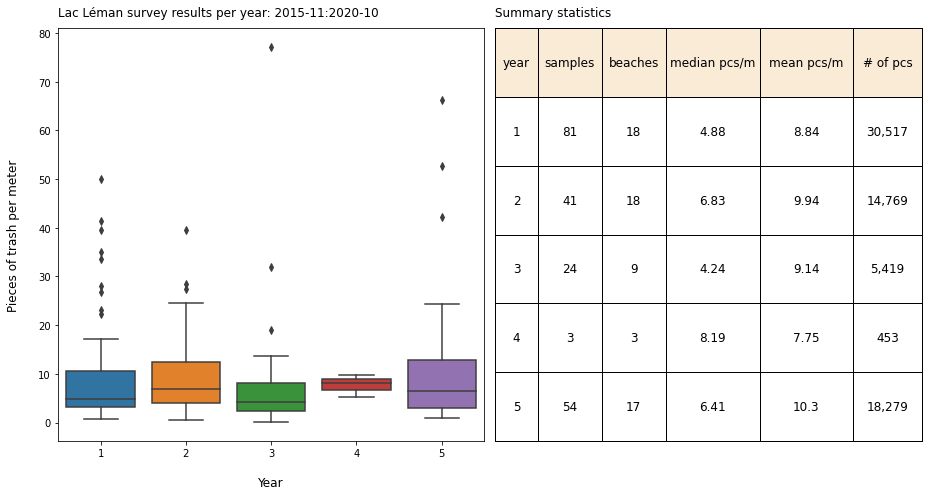

In [5]:
fig_num = 1

this_data = groupdfs['survey total_dt'].copy()

# add the year group columns:
this_data['group'] = this_data.year + 1

# define what values to aggregate
this_agg = {'loc_date':'count', 'location':'nunique', 'pcs_m':['median', 'mean'],  'quantity':'sum', 'date':['min','max']}

# reset the index and aggregate
this_data.reset_index(inplace=True)
tabledata = this_data.groupby('group', as_index=False).agg(this_agg)

# flatten the column index and rename to something plain english
tabledata.columns = [col[1] for col in tabledata.columns.values]
tabledata.rename(columns={"":'year','count':'samples', 'nunique':'beaches', 'median':'median pcs/m', 'mean':'mean pcs/m', 'sum': '# of pcs'}, inplace=True)

# houskeeping for the table
tabledata['median pcs/m']= tabledata['median pcs/m'].round(2)
tabledata['mean pcs/m'] = tabledata['mean pcs/m'].round(2)
tabledata['# of pcs'] = tabledata['# of pcs'].astype('int')
tabledata['# of pcs'] = tabledata['# of pcs'].map(lambda x: '{:,}'.format(x))

# this is to show
tabledata_columns = ['year', 'samples', 'beaches', 'median pcs/m', 'mean pcs/m', '# of pcs']
tabledata = tabledata[tabledata_columns]

# table variables:
tablecenter_k.update({'colWidths':[10, 15, 15, 22, 22, 16]})

# draw chart and table
fig, ax = plt.subplots(1,2,figsize=(13,7))

sns.boxplot(data=this_data, x='group', y='pcs_m', hue='group', dodge=False, ax=ax[0])

handles, labels = ax[0].get_legend_handles_labels()
ax[0].get_legend().remove()
ax[0].set_title(F"{lake} survey results per year: {year_one['start_date'][:7]}:{year_five['end_date'][:7]}", **title_k )
ax[0].set_xlabel("Year", **xlab_k)
ax[0].set_ylabel("Pieces of trash per meter", **xlab_k)



ax1 = make_table_grids(ax[1])
a_table = mpl.table.table(
    cellText=tabledata.values,
    colLabels=tabledata.columns,
    colColours=['antiquewhite' for col in list(tabledata.columns)],    
    ax=ax1,
    **tablecenter_k)

table_fonts(a_table, size=12)


ax1.add_table(a_table)
ax1.tick_params(**tabtickp_k)
ax1.set_title("Summary statistics", **title_k)

a_name = F"figure{fig_num}.jpg"
a_tag = "Survey results, boxplot years 1-5, summary table"

plt.tight_layout()
add_output(a_name, a_tag, atype="figure", fignum=fig_num, a_list=files_generated)

a_name = F"data_figure_one.csv"
a_tag = "Number of samples, locations and summary stats per year"
add_csv_to_output(a_name, a_tag, tabledata, atype="data")



plt.show()
plt.close()

### <span style="color:#1e90ff">Number of surveys per location and sample year</span>

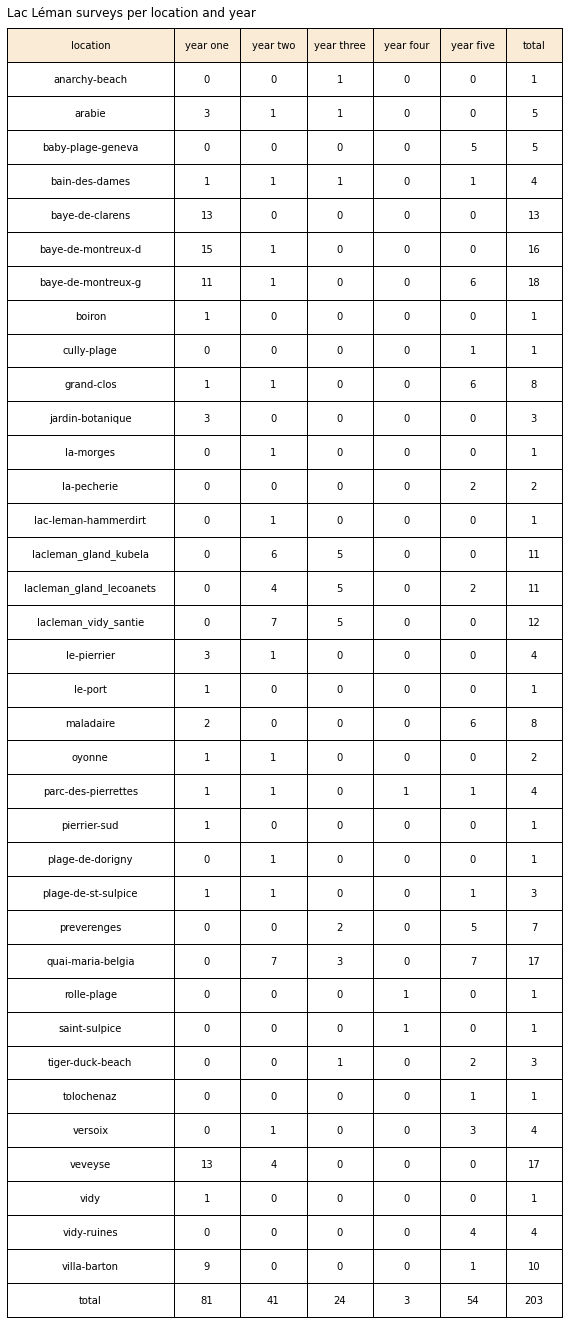

In [6]:
# get all the unique location names in the data
these_beaches = this_data.location.unique()

# make a df from that
surveys_year = pd.DataFrame({'location':these_beaches})

# set up a map to key location to year group
grouped_by_year=this_data.groupby(['group','location']).loc_date.count()


def count_per_year(x,group):
    try:
        # if the location is in this year group take the count
        count = grouped_by_year.loc[group][x]
    except:
        # otherwise the count for that year is zero
        count = 0
    return count

# set the index to location and drop the old one
surveys_year.set_index('location', inplace=True, drop=True)

# for each year group check the count for each location:
for i, name in enumerate(year_names):
    surveys_year[name] = surveys_year.index.map(lambda x: count_per_year(x, i+1))

# add a total column: total surveys at that location
surveys_year.loc[:, 'total'] = surveys_year[['year one', 'year two', 'year three', 'year four', 'year five']].sum(axis=1)

# add a total row: total surveys per year
last_row = surveys_year.sum(axis=0).values
surveys_year.loc['total'] = last_row

# reset the index so that location will be a column
surveys_year.reset_index(inplace=True)


# table variables:
tablecenter_k.update({'colWidths':[30, 12, 12, 12, 12, 12, 10]})


fig_num += 1
fig_height = len(surveys_year)*.5
fig, ax = plt.subplots(figsize=(8,fig_height))

ax1 = make_table_grids(ax)
a_table = mpl.table.table(
    
    cellText=surveys_year.values,
    colLabels=surveys_year.columns,
    colColours=['antiquewhite' for col in list(surveys_year.columns)],    
    ax=ax1,
    **tablecenter_k)

table_fonts(a_table, size=10)


ax1.add_table(a_table)
ax1.tick_params(**tabtickp_k)
ax1.set_title(F"{lake} surveys per location and year", **title_k)

a_name = F"figure{fig_num}.jpg"
a_tag = "detail samples per year and location"

plt.tight_layout()
add_output(a_name, a_tag, atype="table", fignum=fig_num, a_list=files_generated)

a_name = F"data_figure_one.csv"
a_tag = "Number of samples, locations and summary stats per year"
add_csv_to_output(a_name, a_tag, surveys_year, atype="data")



plt.show()
plt.close()

### <span style="color:#1e90ff">Survey totals, pieces per meter</span>

In [7]:
teams = {
    'SWE':['tiger-duck-beach', 'saint-sulpice', 'rolle-plage', 'plage-de-st-sulpice','parc-des-pierrettes'],
    'PC':['preverenges', 'maladaire', 'vidy-ruines'],
    'EINT':['versoix'],
    'ASL':['baby-plage-geneva'],
    'SLR':['lacleman-vidy-santie', 'lacleman_gland_lecoanets', 'lacleman_gland_kubela']
}
a_team_map={}
for team in teams:
    teams_loc = {x:team for x in teams[team]}
    a_team_map.update(teams_loc)
the_team_map = {x:'HD' for x in these_beaches if x not in a_team_map.keys()}
the_team_map = {**a_team_map, **the_team_map}

this_data['team'] = this_data.location.map(lambda x: the_team_map[x])

this_data_a = this_data[this_data.date > "2020-04-01"].copy()

# some locations were surveyed by different groups on different dates

def change_ownership(x, a_list, a_map, an_owner):
    if x in a_list:
        owner = an_owner
    else:
        owner = a_map[x]
    return owner
a_list = ['versoix', 'lacleman_gland_lecoanets']

this_data_a['team'] = this_data_a.location.map(lambda x: change_ownership(x, a_list, the_team_map, 'HD'))
this_data_m = this_data[this_data.date <= "2020-04-01"].copy()
a_list = ['maladaire']
this_data_m['team'] = this_data_m.location.map(lambda x:change_ownership(x, a_list, the_team_map, 'HD'))

this_data = pd.concat([this_data_a, this_data_m])

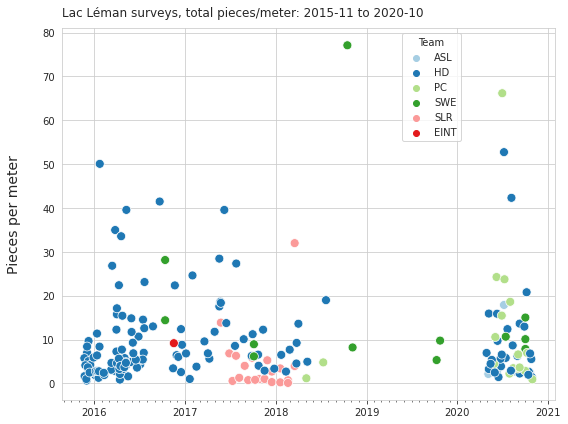

In [8]:
fig_num += 1
a_tag = F"{lake} survey totals scatterplot {year_one['start_date']} to {year_five['end_date']}"
# palette = [(27,158,119), (217,95,2),(117,112,179),(231,41,138),(102,166,30),(230,171,2)]

sns.set_style('whitegrid')
a_name = F"figure{fig_num}.jpg"
fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(which="both", bottom=True)

ax1 = sns.scatterplot(data=this_data, x='date', y='pcs_m', hue='team', palette="Paired", s=80, ax=ax)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, title="Team", bbox_to_anchor=(0.68,1), loc='upper left')
ax1.xaxis.set_minor_locator(allmonths)
ax1.tick_params(which='minor', length=2)
ax1.set_title(F"{lake} surveys, total pieces/meter: {year_one['start_date'][:7]} to {year_five['end_date'][:7]}", **title_k )
ax1.set_ylabel("Pieces per meter", **ylab_k)
ax1.set_xlabel("")

a_name = F"figure{fig_num}.jpg"
a_tag = "Scatter plot all all surveys, grouped by team"

plt.tight_layout()
add_output(a_name, a_tag, atype="table", fignum=fig_num, a_list=files_generated)


plt.show()
plt.close()

In [9]:
team_totals = this_data.groupby('team').loc_date.count()
not_year_four = this_data[this_data.group.isin([1,2,3,5])]

### <span style="color:#1e90ff">Distribution of results and empirical cumulative distribution</span>

In [10]:
year_colors = {1:'indigo', 2:'pink', 3:'dodgerblue', 4:'red', 5:'seagreen'}
year_four = this_data[this_data.group == 4]

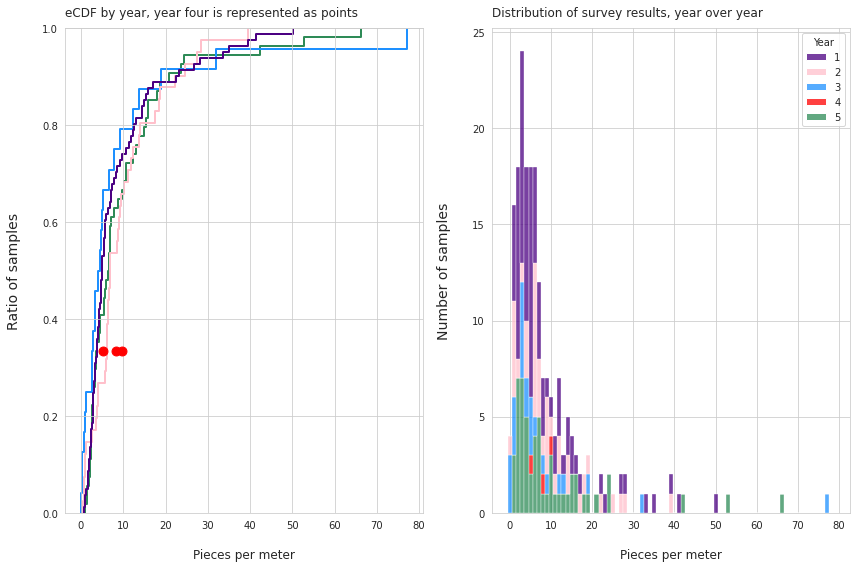

In [11]:
fig, axs = plt.subplots(1,2,figsize=(12,8))

ax1 = sns.ecdfplot(data=not_year_four, x='pcs_m', hue='group', palette=year_colors, linewidth=2, ax=axs[0], zorder=0)
ax1.scatter(x=year_four.pcs_m.values, y=[1/3 for i in np.arange(3)], c='red', s=80, zorder=1)
ax1.set_title(F"eCDF by year, year four is represented as points", **title_k)
ax1.set_ylabel("Ratio of samples", **ylab_k)
ax1.set_xlabel("Pieces per meter", **xlab_k)
ax1.get_legend().remove()


ax2 = sns.histplot(data=this_data, x='pcs_m', hue='group', palette=year_colors, ax=axs[1], discrete=True, stat='count', multiple='stack')
ax2.set_title(F"Distribution of survey results, year over year", **title_k)
ax2.set_ylabel("Number of samples", **ylab_k)
ax2.set_xlabel("Pieces per meter", **xlab_k)
ax2.get_legend().set_title("Year")


plt.tight_layout()
plt.show()
plt.close()

#### Hopefully that just worked for you

if not contact analyst@hammerdirt.ch

In [12]:
# def css_styling():
#     styles = open(F"{project_directory}/custom.css").read()
#     return HTML(styles)
# css_styling()